# Load data

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import FrameVideoDataset

root_dir = r"ufc10"

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on: {device}')

# Define transforms for different model types*
transform_pretrained = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_3d = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and loaders for different model types
test_dataset_pretrained = FrameVideoDataset(root_dir=root_dir, split='test', 
                                          transform=transform_pretrained, stack_frames=True)
test_dataset_3d = FrameVideoDataset(root_dir=root_dir, split='test', 
                                   transform=transform_3d, stack_frames=True)

test_loader_pretrained = DataLoader(test_dataset_pretrained, batch_size=8, shuffle=False)
test_loader_3d = DataLoader(test_dataset_3d, batch_size=8, shuffle=False)

Running on: cuda


# Load models

In [2]:
import os
import torch
from aggregation_model import Pretrained
from early_fusion import EarlyFusionModel
from late_fusion import LateFusion
from model3d import TheConvolver3D

# Directory containing the saved model files
models_dir = r"../saved_models/"

# Define the model paths
model_paths = {
    "Aggregation": os.path.join(models_dir, "Pretrained_best.pth"),
    "EarlyFusionModel": os.path.join(models_dir, "EarlyFusionModel_best.pth"),
    "LateFusionAVGPool": os.path.join(models_dir, "LateFusionAVGPool_best.pth"),
    "LateFusionMLP": os.path.join(models_dir, "LateFusionMLP_best.pth"),
    "3DConv": os.path.join(models_dir, "TheConvolver3D_best.pth")
}

hyperparameters = {
    'num_classes': 10,
}


# Initialize the models
models = {
    "Aggregation": Pretrained( pretrained=False, freeze_backbone = False),
    "EarlyFusionModel": EarlyFusionModel(hyperparameters=hyperparameters, load_pretrained=False, use_lstm=False),
    "LateFusionAVGPool": LateFusion(hyperparameters=hyperparameters, load_pretrained=False, fusion_type='avg_pool'),
    "LateFusionMLP": LateFusion(hyperparameters=hyperparameters, load_pretrained=False, fusion_type='mlp'),
    "3DConv": TheConvolver3D()
}

for model_name, model in models.items():
    model_path = model_paths[model_name]
    if os.path.exists(model_path):
        checkpoint = torch.load(model_path)  # Load checkpoint
        model.load_state_dict(checkpoint["model_state_dict"])  # Load model weights
        model.eval()  # Set the model to evaluation mode
        print(f"{model_name} loaded successfully.")
    else:
        print(f"Model file for {model_name} not found at {model_path}.")



C:\Users\gtoft\AppData\Local\Temp\ipykernel_36764\992528521.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)  # Load checkpoint


Aggregation loaded successfully.
EarlyFusionModel loaded successfully.
LateFusionAVGPool loaded successfully.
LateFusionMLP loaded successfully.
3DConv loaded successfully.


# Inference

In [3]:
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import FrameVideoDataset, FrameImageDataset

In [4]:
# Initialize results
y_true = []
predictions = {model_name: [] for model_name in models.keys()}

# Run inference one model at a time
for model_name, model in models.items():
    print(f"Running inference for model: {model_name}")
    
    model.to(device)
    model.eval()
    
    # Select appropriate loader based on model type
    if model_name == "3DConv":
        loader = test_loader_3d
    else:
        loader = test_loader_pretrained
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(tqdm(loader, desc=f"Testing {model_name}")):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Store true labels (only need to do this once per loader)
            if len(y_true) < len(test_dataset_3d):  # Only store if not already stored
                y_true.extend(labels.cpu().numpy())
            
            try:
                # Handle different input requirements for different models
                if model_name == "Aggregation":
                    # Reshape input for Pretrained model
                    batch_size, channels, frames, height, width = inputs.shape
                    inputs = inputs.view(-1, channels, height, width)
                    outputs = model(inputs)
                    outputs = outputs.view(batch_size, frames, -1).mean(dim=1)
                else:
                    outputs = model(inputs)
                
                # Get predictions
                _, predicted = torch.max(outputs.data, 1)
                predictions[model_name].extend(predicted.cpu().numpy())
                
            except Exception as e:
                print(f"Error processing batch for {model_name}: {str(e)}")
                continue
    
    # Move model back to CPU and clear cache
    model = model.cpu()
    torch.cuda.empty_cache()

# Convert to numpy arrays
y_true = np.array(y_true)
for model_name in predictions.keys():
    predictions[model_name] = np.array(predictions[model_name])

print("\nInference completed for all models.")
print(f"Number of test samples: {len(y_true)}")
for model_name in predictions.keys():
    print(f"Number of predictions for {model_name}: {len(predictions[model_name])}")

Running inference for model: Aggregation


Testing Aggregation: 100%|██████████| 15/15 [00:47<00:00,  3.17s/it]


Running inference for model: EarlyFusionModel


Testing EarlyFusionModel: 100%|██████████| 15/15 [00:07<00:00,  1.95it/s]


Running inference for model: LateFusionAVGPool


Testing LateFusionAVGPool: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s]


Running inference for model: LateFusionMLP


Testing LateFusionMLP: 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


Running inference for model: 3DConv


Testing 3DConv: 100%|██████████| 15/15 [00:01<00:00, 12.33it/s]


Inference completed for all models.
Number of test samples: 120
Number of predictions for Aggregation: 120
Number of predictions for EarlyFusionModel: 120
Number of predictions for LateFusionAVGPool: 120
Number of predictions for LateFusionMLP: 120
Number of predictions for 3DConv: 120


# Friedman Test: Non-parametric alternative to ANOVA

In [5]:
from sklearn.metrics import classification_report, accuracy_score

# Calculate metrics for each model
results = {}
for model_name, preds in predictions.items():
    # Generate a classification report
    report = classification_report(y_true, preds, output_dict=True, zero_division=0)
    
    # Extract key metrics
    results[model_name] = {
        "Accuracy": accuracy_score(y_true, preds),
        "Macro F1": report["macro avg"]["f1-score"],
        "Weighted F1": report["weighted avg"]["f1-score"]
    }

# Display results
import pandas as pd
df_results = pd.DataFrame(results).T
print(df_results)


                   Accuracy  Macro F1  Weighted F1
Aggregation        0.733333  0.736030     0.736030
EarlyFusionModel   0.891667  0.890839     0.890839
LateFusionAVGPool  0.983333  0.983319     0.983319
LateFusionMLP      0.950000  0.951185     0.951185
3DConv             0.741667  0.741098     0.741098


In [6]:
import numpy as np

# Bootstrap sampling to generate metric distributions
n_iterations = 1000
bootstrap_metrics = {model_name: [] for model_name in models.keys()}

for i in range(n_iterations):
    indices = np.random.choice(len(y_true), len(y_true), replace=True)
    for model_name, preds in predictions.items():
        # Get bootstrap samples
        bootstrap_y_true = [y_true[idx] for idx in indices]
        bootstrap_preds = [preds[idx] for idx in indices]
        
        # Calculate macro F1-score with zero_division=0
        f1 = classification_report(bootstrap_y_true, 
                                 bootstrap_preds, 
                                 output_dict=True,
                                 zero_division=0)["macro avg"]["f1-score"]
        bootstrap_metrics[model_name].append(f1)

# Compute confidence intervals for each model
for model_name, f1_scores in bootstrap_metrics.items():
    lower = np.percentile(f1_scores, 2.5)
    upper = np.percentile(f1_scores, 97.5)
    print(f"{model_name}: 95% CI for Macro F1: {lower:.4f} - {upper:.4f}")


Aggregation: 95% CI for Macro F1: 0.6487 - 0.8042
EarlyFusionModel: 95% CI for Macro F1: 0.8239 - 0.9408
LateFusionAVGPool: 95% CI for Macro F1: 0.9554 - 1.0000
LateFusionMLP: 95% CI for Macro F1: 0.9057 - 0.9830
3DConv: 95% CI for Macro F1: 0.6467 - 0.8150


In [7]:
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman

# Prepare metric matrix
metric_matrix = np.array([bootstrap_metrics[model_name] for model_name in models.keys()])

# Perform Friedman Test
stat, p_value = friedmanchisquare(*metric_matrix)
print(f"Friedman Test: p = {p_value:.4f}")

# Post-hoc Nemenyi Test if p < 0.05
if p_value < 0.05:
    nemenyi_results = posthoc_nemenyi_friedman(metric_matrix.T)
    print("Post-hoc Test Results (Nemenyi):")
    print(nemenyi_results)


Friedman Test: p = 0.0000
Post-hoc Test Results (Nemenyi):
              0             1             2             3             4
0  1.000000e+00  1.110223e-16  1.110223e-16  1.110223e-16  6.367432e-01
1  1.110223e-16  1.000000e+00  1.110223e-16  1.110223e-16  1.110223e-16
2  1.110223e-16  1.110223e-16  1.000000e+00  1.110223e-16  1.110223e-16
3  1.110223e-16  1.110223e-16  1.110223e-16  1.000000e+00  1.110223e-16
4  6.367432e-01  1.110223e-16  1.110223e-16  1.110223e-16  1.000000e+00


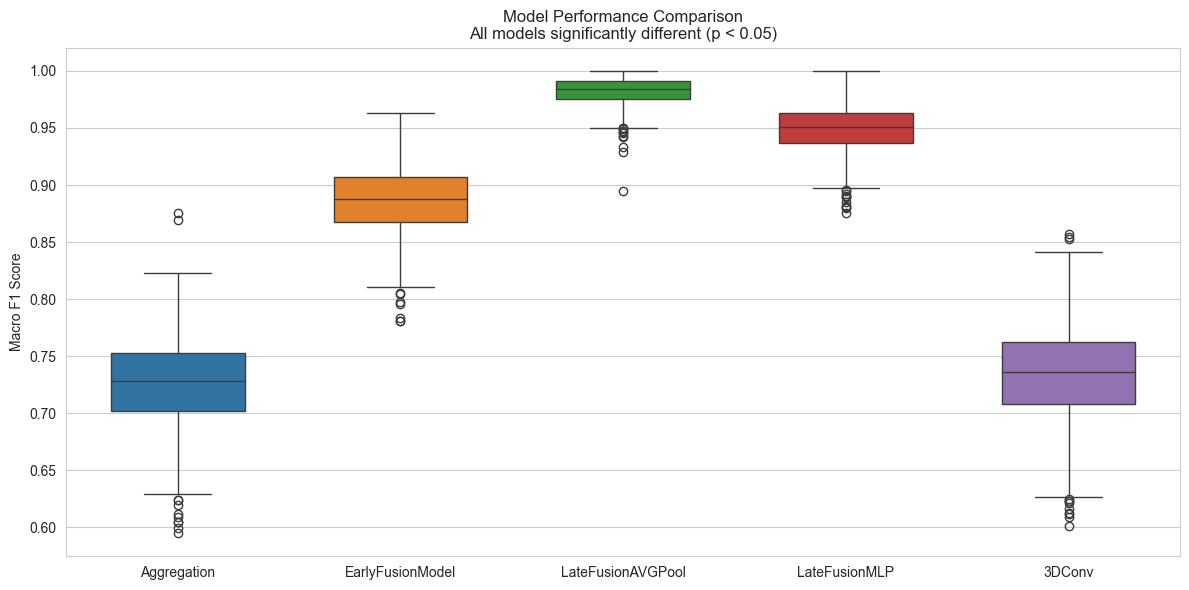

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set style and figure size
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create boxplot
sns.boxplot(data=[bootstrap_metrics[model_name] for model_name in models.keys()], 
            width=0.6)

# Customize the plot
plt.xticks(range(len(models)), models.keys())
plt.ylabel("Macro F1 Score")
plt.title("Model Performance Comparison\nAll models significantly different (p < 0.05)")

plt.tight_layout()
plt.show()

Class-wise F1 scores (sorted by difficulty - hardest first):
                   Aggregation  EarlyFusionModel  LateFusionAVGPool  \
HandstandWalking      0.523810          0.761905           1.000000   
Lunges                0.285714          0.956522           0.960000   
BodyWeightSquats      0.666667          0.846154           0.916667   
PushUps               0.800000          0.888889           1.000000   
PullUps               0.833333          0.880000           1.000000   
WallPushups           0.857143          0.916667           0.956522   
TrampolineJumping     0.705882          0.909091           1.000000   
JumpRope              0.909091          0.956522           1.000000   
JumpingJacks          0.909091          0.923077           1.000000   
HandstandPushups      0.869565          0.869565           1.000000   

                   LateFusionMLP    3DConv  support    avg_f1  
HandstandWalking        0.880000  0.631579     12.0  0.759459  
Lunges                  0.956

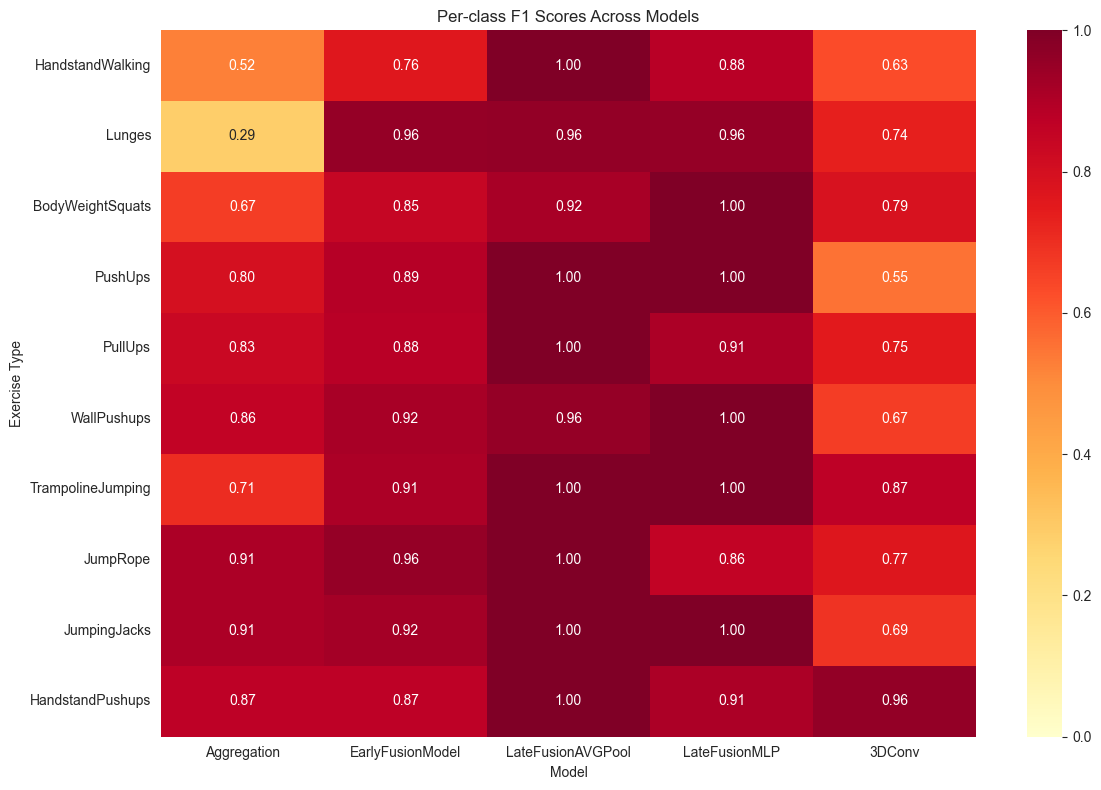

In [9]:
from sklearn.metrics import classification_report
import pandas as pd

# Class name mapping
class_names = [
    'BodyWeightSquats',
    'HandstandPushups',
    'HandstandWalking',
    'JumpingJacks',
    'JumpRope',
    'Lunges',
    'PullUps',
    'PushUps',
    'TrampolineJumping',
    'WallPushups'
]

# Create a dictionary to store per-class metrics for each model
class_performance = {}

for model_name, preds in predictions.items():
    # Get the full classification report
    report = classification_report(y_true, preds, output_dict=True, zero_division=0)
    
    # Create a mapping from numeric indices to class names
    class_metrics = {}
    for i, name in enumerate(class_names):
        if str(i) in report:
            class_metrics[name] = report[str(i)]
    
    # Convert to DataFrame
    df = pd.DataFrame(class_metrics).T
    df = df[['precision', 'recall', 'f1-score', 'support']]
    
    class_performance[model_name] = df

# Create a comparison of F1 scores across models for each class
f1_comparison = pd.DataFrame({
    model_name: class_performance[model_name]['f1-score']
    for model_name in models.keys()
}, index=class_names)

# Add support (number of samples) column
f1_comparison['support'] = class_performance[list(models.keys())[0]]['support']

# Sort classes by average F1 score to identify most difficult classes
f1_comparison['avg_f1'] = f1_comparison.drop('support', axis=1).mean(axis=1)
f1_comparison = f1_comparison.sort_values('avg_f1', ascending=True)

print("Class-wise F1 scores (sorted by difficulty - hardest first):")
print(f1_comparison)

# Create a heatmap visualization
plt.figure(figsize=(12, 8))
sns.heatmap(f1_comparison.drop(['support', 'avg_f1'], axis=1), 
            annot=True, 
            fmt='.2f', 
            cmap='YlOrRd',
            vmin=0, 
            vmax=1)
plt.title('Per-class F1 Scores Across Models')
plt.xlabel('Model')
plt.ylabel('Exercise Type')
plt.xticks()
plt.tight_layout()
plt.show()

# No leaks comparison

In [10]:
from datasets_new import FrameVideoDataset
from train_twostream import get_dataloaders

import os

root_dir = os.path.join(os.getcwd(), 'ucf101_noleakage')
# For TwoStream model
spatial_loader_test, flow_loader_test = get_dataloaders(
    root_dir, 
    batch_size,
    num_frames=10,
    mode='test'  
)

# For regular models
test_loader = DataLoader(test_dataset_pretrained, batch_size=batch_size, shuffle=False)

Loaded 120 videos and 120 metadata entries
Loaded 120 videos and 120 metadata entries


In [11]:
print("Checking dataset structure...")
expected_dirs = ['frames', 'flows', 'videos', 'metadata']
for dir_name in expected_dirs:
    path = os.path.join(root_dir, dir_name)
    print(f"Does {dir_name} exist?", os.path.exists(path))

Checking dataset structure...
Does frames exist? True
Does flows exist? True
Does videos exist? True
Does metadata exist? True


In [12]:
from TwoStreamNetwork import TwoStream
# Directory containing the saved model files
models_dir = r"../saved_models/"

# Define the model paths
model_paths = {
    "EarlyFusionNoLeaks": os.path.join(models_dir, "EarlyFusionModelNoLeaks_best.pth"),
    "TwoStream": os.path.join(models_dir, "TwoStream_best_model.pth"),
}

hyperparameters = {
    'num_classes': 10,
}




# Initialize the models
models = {
    "EarlyFusionNoLeaks": EarlyFusionModel(hyperparameters=hyperparameters, load_pretrained=False, use_lstm=False),
    "TwoStream": TwoStream(
        hyperparameters=hyperparameters,
        timesteps=10
    ),
}

for model_name, model in models.items():
    model_path = model_paths[model_name]
    if os.path.exists(model_path):
        checkpoint = torch.load(model_path)  # Load checkpoint
        model.load_state_dict(checkpoint["model_state_dict"])  # Load model weights
        model.eval()  # Set the model to evaluation mode
        print(f"{model_name} loaded successfully.")
    else:
        print(f"Model file for {model_name} not found at {model_path}.")


C:\Users\gtoft\AppData\Local\Temp\ipykernel_36764\537638901.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)  # Load checkpoint


EarlyFusionNoLeaks loaded successfully.
TwoStream loaded successfully.


In [14]:
import torch.nn.functional as F 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move all models to the appropriate device
for model_name, model in models.items():
    models[model_name] = model.to(device)

# Create separate predictions dictionary
predictions = {}

# Run inference for each model
for model_name, model in models.items():
    print(f"Running inference for model: {model_name}")
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        if model_name == "TwoStream":
            # Two-stream specific inference
            for (spatial_frames, _), (flow_frames, labels) in zip(spatial_loader_test, flow_loader_test):
                # Move both inputs to device
                spatial_frames = spatial_frames.to(device)
                flow_frames = flow_frames.to(device)
                labels = labels.to(device)
                
                B, C, T, H, W = spatial_frames.size()
                
                # Process spatial frames
                spatial_frames = spatial_frames.transpose(1, 2)
                spatial_frames = spatial_frames.reshape(-1, C, H, W)
                

                # Process flow frames
                B_flow, C_flow, H_flow, W_flow = flow_frames.size()
                flow_frames = flow_frames.unsqueeze(1)
                flow_frames = flow_frames.expand(-1, T, -1, -1, -1)
                flow_frames = flow_frames.reshape(B*T, -1, H_flow, W_flow)
                
                # Resize flow frames if needed
                if H_flow != H or W_flow != W:
                    flow_frames = F.interpolate(flow_frames, size=(H, W), 
                                             mode='bilinear', align_corners=False)
                
                # Forward pass
                outputs = model(spatial_frames, flow_frames)
                outputs = outputs.view(B, T, -1)
                outputs = outputs.mean(dim=1)
                
                # Get predictions
                _, predicted = outputs.max(1)
                all_preds.extend(predicted.cpu().numpy())
        else:
            
            # Regular inference for other models
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)  # Move labels to device if needed
                
                # Forward pass
                outputs = model(inputs)
                
                # Get predictions
                _, predicted = outputs.max(1)
                all_preds.extend(predicted.cpu().numpy())
    
    predictions[model_name] = all_preds
    print(f"Number of predictions for {model_name}: {len(all_preds)}")

Running inference for model: EarlyFusionNoLeaks
Number of predictions for EarlyFusionNoLeaks: 120
Running inference for model: TwoStream
Looking for video_name=v_PushUps_g16_c02
Found 1 matches
First match: {'video_name': 'v_PushUps_g16_c02', 'video_path': 'PushUps/v_PushUps_g16_c02.avi', 'action': 'PushUps', 'group': 'g16', 'label': 7}
Looking for video_name=v_HandstandWalking_g19_c03
Found 1 matches
First match: {'video_name': 'v_HandstandWalking_g19_c03', 'video_path': 'HandstandWalking/v_HandstandWalking_g19_c03.avi', 'action': 'HandstandWalking', 'group': 'g19', 'label': 2}
Looking for video_name=v_WallPushups_g19_c03
Found 1 matches
First match: {'video_name': 'v_WallPushups_g19_c03', 'video_path': 'WallPushups/v_WallPushups_g19_c03.avi', 'action': 'WallPushups', 'group': 'g19', 'label': 9}
Looking for video_name=v_JumpRope_g24_c02
Found 1 matches
First match: {'video_name': 'v_JumpRope_g24_c02', 'video_path': 'JumpRope/v_JumpRope_g24_c02.avi', 'action': 'JumpRope', 'group': 'g24

Number of test samples: 120
Number of predictions for EarlyFusionNoLeaks: 120
Number of predictions for TwoStream: 120
EarlyFusionNoLeaks: 95% CI for Macro F1: 0.0187 - 0.0857
TwoStream: 95% CI for Macro F1: 0.0574 - 0.1626

Wilcoxon signed-rank test: p = 0.0000
Interpretation:
There is a statistically significant difference between the models (p < 0.05)
TwoStream performs significantly better

Overall Performance Metrics:
                    Accuracy  Macro F1  Weighted F1
EarlyFusionNoLeaks  0.108333  0.052381     0.052381
TwoStream           0.116667  0.113023     0.113023


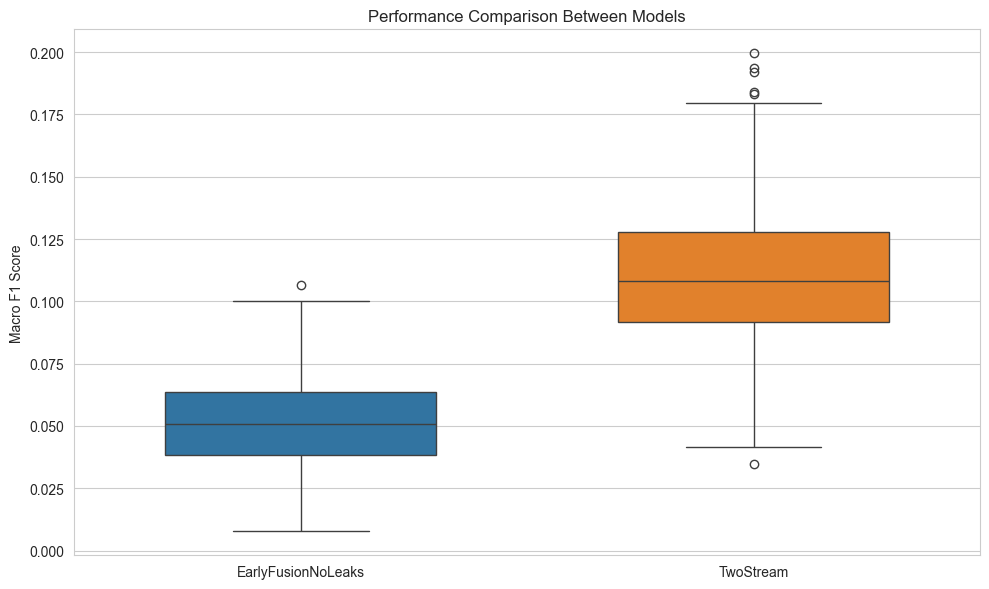


Effect size (Cohen's d): -2.5583
Interpretation:
Large effect


In [17]:
import numpy as np
from sklearn.metrics import classification_report
from scipy.stats import wilcoxon

# First ensure we have ground truth labels
y_true = []
for _, labels in test_loader:
    y_true.extend(labels.numpy())

# Bootstrap sampling to generate metric distributions
n_iterations = 1000
bootstrap_metrics = {model_name: [] for model_name in models.keys()}

print(f"Number of test samples: {len(y_true)}")
for model_name, preds in predictions.items():
    print(f"Number of predictions for {model_name}: {len(preds)}")

for i in range(n_iterations):
    indices = np.random.choice(len(y_true), len(y_true), replace=True)
    for model_name, preds in predictions.items():
        # Get bootstrap samples
        bootstrap_y_true = [y_true[idx] for idx in indices]
        bootstrap_preds = [preds[idx] for idx in indices]
        
        # Calculate macro F1-score
        f1 = classification_report(bootstrap_y_true, bootstrap_preds, 
                                 output_dict=True,
                                 zero_division=0)["macro avg"]["f1-score"]
        bootstrap_metrics[model_name].append(f1)

# Compute confidence intervals for each model
for model_name, f1_scores in bootstrap_metrics.items():
    lower = np.percentile(f1_scores, 2.5)
    upper = np.percentile(f1_scores, 97.5)
    print(f"{model_name}: 95% CI for Macro F1: {lower:.4f} - {upper:.4f}")

# Perform Wilcoxon signed-rank test
model_names = list(models.keys())
stat, p_value = wilcoxon(bootstrap_metrics[model_names[0]], 
                        bootstrap_metrics[model_names[1]])
print(f"\nWilcoxon signed-rank test: p = {p_value:.4f}")
print("Interpretation:")
if p_value < 0.05:
    better_model = model_names[0] if np.mean(bootstrap_metrics[model_names[0]]) > np.mean(bootstrap_metrics[model_names[1]]) else model_names[1]
    print(f"There is a statistically significant difference between the models (p < 0.05)")
    print(f"{better_model} performs significantly better")
else:
    print("No statistically significant difference between the models (p >= 0.05)")

# Create performance table
print("\nOverall Performance Metrics:")
performance_metrics = {}
for model_name, preds in predictions.items():
    report = classification_report(y_true, preds, output_dict=True, zero_division=0)
    performance_metrics[model_name] = {
        'Accuracy': report['accuracy'],
        'Macro F1': report['macro avg']['f1-score'],
        'Weighted F1': report['weighted avg']['f1-score']
    }

import pandas as pd
metrics_df = pd.DataFrame(performance_metrics).T
print(metrics_df)

# Visualize results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=[bootstrap_metrics[model_name] for model_name in models.keys()], 
            width=0.6)
plt.xticks(range(len(models)), models.keys())
plt.ylabel("Macro F1 Score")
plt.title("Performance Comparison Between Models")
plt.tight_layout()
plt.show()

# Add effect size calculation (Cohen's d)
def cohens_d(x1, x2):
    n1, n2 = len(x1), len(x2)
    var1, var2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
    pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (np.mean(x1) - np.mean(x2)) / pooled_se

d = cohens_d(bootstrap_metrics[model_names[0]], bootstrap_metrics[model_names[1]])
print(f"\nEffect size (Cohen's d): {d:.4f}")
print("Interpretation:")
if abs(d) < 0.2:
    print("Negligible effect")
elif abs(d) < 0.5:
    print("Small effect")
elif abs(d) < 0.8:
    print("Medium effect")
else:
    print("Large effect")